# Analysis



In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib_venn import venn2, venn3

pd.set_option("display.precision", 2)

In [3]:
sns.set_style("darkgrid")

In [4]:
urls_csv = "../data/urls.csv"
metrics_csv = "../data/metrics.csv"
details_csv = "../data/details.csv"

### Load data

In [5]:
urls = pd.read_csv(urls_csv, parse_dates=['added_on'])
details = pd.read_csv(details_csv, index_col="id", parse_dates=['og_updated_time'])
metrics = pd.read_csv(metrics_csv, index_col="doi")

metrics.rename(columns={'facebook': 'public_fb',
                        'shares': 'private_fb_api',
                        'diff': 'fb_diff_api',
                        'reactions': 'fb_reactions_api',
                        'comments' : 'fb_comments_api'}, inplace=True)
del metrics['total']

In [6]:
fb_metrics = ['private_fb', 'fb_comments', 'fb_reactions']
for _ in fb_metrics:
    metrics[_] = metrics[_+"_api"][metrics[_+"_api"] != 0]
metrics['diff'] = metrics['private_fb'] - metrics['public_fb']

In [7]:
metrics[['public_fb', 'private_fb_api', 'fb_reactions_api', 'fb_comments_api']].describe()

,public_fb,private_fb_api,fb_reactions_api,fb_comments_api
count,18521.00,101603.00,101603.00,101603.00
mean,3.03,54.19,80.08,38.74
std,21.61,599.20,840.10,420.72
min,1.00,0.00,0.00,0.00
25%,1.00,0.00,0.00,0.00
50%,1.00,0.00,0.00,0.00
75%,2.00,1.00,0.00,0.00
max,2428.00,12473.00,36030.00,15241.00


In [8]:
fb_metrics = metrics[['public_fb', 'private_fb', 'fb_reactions', 'fb_comments', 'diff']]
fb_metrics.describe()

,public_fb,private_fb,fb_reactions,fb_comments,diff
count,18521.00,35477.00,22361.00,17199.00,13055.00
mean,3.03,155.18,363.87,228.86,80.76
std,21.61,1006.28,1761.72,1001.08,700.40
min,1.00,1.00,1.00,1.00,-2393.00
25%,1.00,1.00,4.00,2.00,0.00
50%,1.00,2.00,13.00,6.00,2.00
75%,2.00,4.00,41.00,15.00,7.00
max,2428.00,12473.00,36030.00,15241.00,12427.00


## Statistics about link distribution and sharing

In [9]:
# Link types that were shared once at least
type_count = details.type.value_counts()
df = pd.concat([type_count, (type_count/type_count.sum()*100).astype(object)], axis=1)
df.columns = ["n", "%"]
df

,n,%
landing,89995,61
doi_old,38111,26
metrics,11525,7.9
pdf,3996,2.7
doi,1932,1.3
authors,534,0.36
related,185,0.13
comments,183,0.12
pmid,70,0.048
pmc,70,0.048


In [15]:
cols = ['shares']
a = details.reset_index().groupby(["type", "og_id"])[cols].first().groupby(["type"]).mean()
a['mean'] = details.reset_index().groupby(["type", "og_id"])[cols].first().groupby(["type"]).median()
a['n'] = details.reset_index().groupby(["type", "og_id"]).first().groupby(["type"]).size()
a

,shares,mean,n
type,,,
authors,81.85,3,533
comments,241.59,2,181
doi,37.76,2,1921
doi_old,5.12,0,37141
landing,2.26,0,89855
metrics,5.82,0,11524
pdf,0.47,0,3987
pmc,1.62,0,66
pmid,0.61,0,64


### Open Graph IDs per article

In [10]:
diff_ogids = details.groupby(["doi", "og_id"]).size().groupby(['doi']).value_counts()
temp = diff_ogids.value_counts()
df = pd.concat([temp, (temp/temp.sum()*100).astype(object)], axis=1)
df.columns = ["n", "%"]
df

,n,%
1,82852,80
2,20334,20
3,468,0.45
4,15,0.014
5,4,0.0039


### Numbers of links that were shared per article

In [11]:
fb_metrics.apply(lambda x: 100*x.notnull().sum()/len(x))

public_fb       15.78
private_fb      30.22
fb_reactions    19.05
fb_comments     14.65
diff            11.12
dtype: float64

In [12]:
# How many different links were shared per article
diff_links = details.groupby(["doi"])['og_id'].size()
df = diff_links.value_counts()
df = pd.concat([df, (df/df.sum()*100).astype(object)], axis=1)
df.columns = ["n", "%"]
df.head()

,n,%
1,61732,61
2,35944,35
3,3285,3.2
4,400,0.39
5,109,0.11


In [13]:
# type of links if only one share
details[details.doi.isin(diff_links[diff_links <= 1].index)].type.value_counts()

landing    50146
doi_old    11245
pdf          338
metrics        2
doi            1
Name: type, dtype: int64

## Coverage

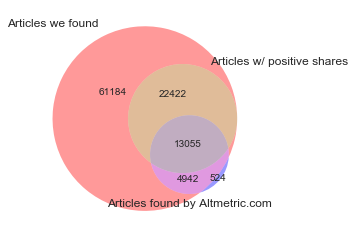

In [55]:
public = set(metrics['public_fb'].dropna().index.tolist())
private_fb_api = set(metrics['private_fb_api'].dropna().index.tolist())
private_fb = set(metrics['private_fb'].dropna().index.tolist())

venn3([private_fb_api, private_fb, public], set_labels=('Articles we found', 'Articles w/ positive shares', 'Articles found by Altmetric.com'));

> "As a consequence of this, it is not possible to be sure that articles with zero values for an altmetric should not have positive scores (unlike [42] for example). It is  ore certain that articles with a positive score on an altmetric had their data effectively collected with that altmetric and so data for articles with non-zero altmetric scores is the most reliable and is the only data used in this article." (Thelwall, Haustein, Larivière, & Sugimoto, 2013, p.3)

In [1]:
x, y, h = (30, 15, 6)
plt.figure(figsize=(h*(x/y),h))

pdf = metrics[['facebook', 'shares>0']].dropna()

# add noice to jitter scatterplot
v,w = t['shares>0'] + np.random.normal(0,.2,len(pdf)), pdf['facebook'] + np.random.normal(0,.2,len(pdf))

sns.kdeplot(pdf['shares>0'], pdf['facebook'], clip=(0,200), cmap='magma_r', alpha=.7)
plt.scatter(v, w, marker='x', color='r', alpha=0.2)
# diagonal
plt.plot(range(0,1000))

s = t[(t['shares>0']<=x) & (t['facebook']<=y)]
plt.title("{:.2f}% of all datapoints".format(100*len(s)/len(t)))
plt.ylabel('Public')
plt.xlabel('Private')

plt.ylim(0,y)
plt.xlim(0,x)

NameError: name 'plt' is not defined

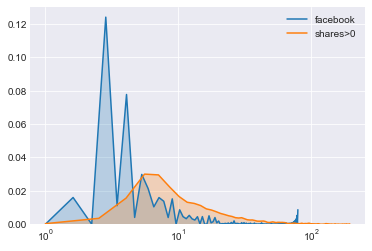

In [15]:
sns.kdeplot(t['facebook'].dropna(), clip=(0,200), shade=True, cut=0)
sns.kdeplot(t['shares>0'].dropna(), clip=(0,200), shade=True, cut=0)

plt.xscale("log")
# plt.yscale("log")

In [35]:
(metrics['diff>0']>0).sum(), (metrics['diff>0']==0).sum(), (metrics['diff>0']<0).sum()

(1643, 606, 158)

(0, 33)

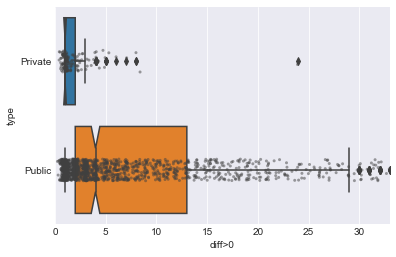

In [95]:
pdf = metrics[metrics['diff>0'] != 0][['diff>0']].copy()
pdf['type'] = pdf['diff>0'].map(lambda x: "Public" if x > 0 else "Private")
pdf['diff>0'] = pdf['diff>0'].abs()
sns.boxplot(x="diff>0", y="type", data=pdf, notch=True)
pdf['diff>0'] = pdf['diff>0'] + np.random.normal(0,.25,len(pdf))
sns.stripplot(x="diff>0", y="type", data=pdf, jitter=True, color=".25", alpha=.5, size=3)
plt.xlim(0, 33)

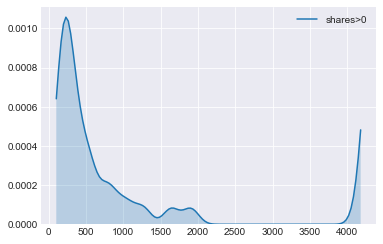

In [18]:
sns.kdeplot(metrics['shares>0'].dropna(), clip=(100,5000), shade=True, cut=0)

(-80, 100)

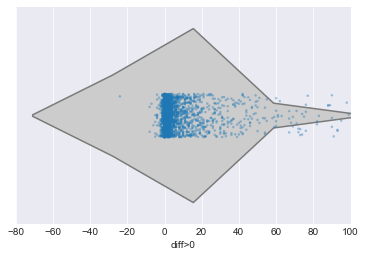

In [37]:
#ax = sns.distplot(diff, hist=False, norm_hist=True);
d = metrics['diff>0'].dropna()
ax = sns.violinplot(metrics['diff>0'], inner=None, color=".8")
# ax = sns.stripplot(x=diff, jitter=True, alpha=.25)
ax = sns.stripplot(metrics['diff>0'], size=2.5, jitter=True, alpha=.4)
plt.xlim(-80, 100)

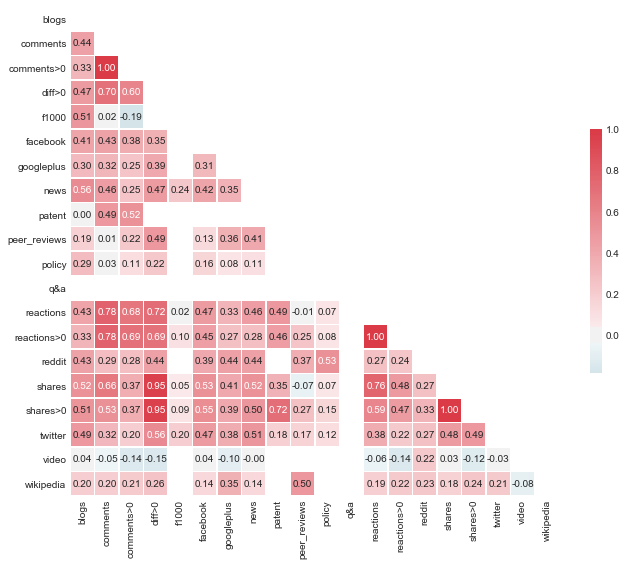

In [10]:
# Compute the correlation matrix
corr = metrics[metrics.columns.difference(['total', 'diff'])].corr(method="spearman")

# Draw the heatmap with the mask and correct aspect ratio
with sns.axes_style("white"):
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, annot=True, fmt=".2f",
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

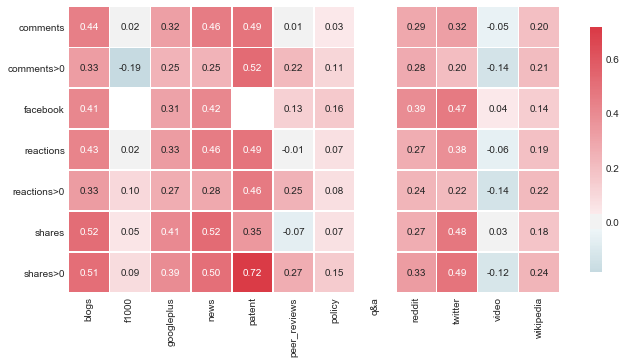

In [13]:
# Compute the correlation matrix
corr = metrics[metrics.columns.difference(['total', 'diff', 'diff>0'])].corr(method="spearman")
corr = corr.loc[fb_metrics+[_+">0" for _ in fb_metrics]+['facebook'], corr.columns.difference(fb_metrics+[_+">0" for _ in fb_metrics]+['facebook'])]
corr = corr.sort_index()

# Draw the heatmap with the mask and correct aspect ratio
with sns.axes_style("white"):
    # Generate a mask for the upper triangle
#   mask = np.zeros_like(corr, dtype=np.bool)
#   mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.heatmap(corr, cmap=cmap, center=0, annot=True, fmt=".2f",
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

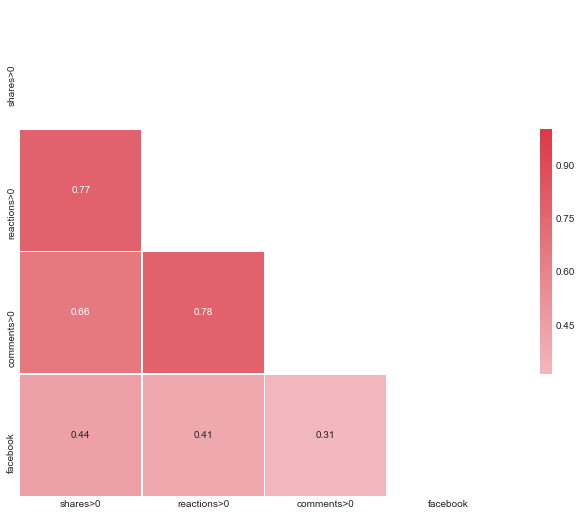

In [33]:
# Compute the correlation matrix

corr = metrics[['shares>0', 'reactions>0', 'comments>0', 'facebook']].fillna(0).corr(method="spearman")

# Draw the heatmap with the mask and correct aspect ratio
with sns.axes_style("white"):
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, annot=True, fmt=".2f",
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Others